I had found two promising ways to adress the anomaly detection problem

1/ The first way was based on the paper Althubiti, Sara; Yuan, Xiaohong; and Esterline, Albert, "Analyzing HTTP requests for web intrusion detection" (2017). In this paper the authors examined the features used by other authorss and extracted the 5 most useful ones using his custom method. The paper claims that they had managed to obtain 99.94% Detection rate. THe features are length of the request, lenght of the arguments, number of arguments, length of the path, number of special chars in the path. Unfortunately the exact specifics of the features are were not provided. I had tried to deduct the specifics from the names, but for example with the special chars in the path I am not sure which exact chars they had in mind. In my implementation I had only managed to get 90% Detection rate. This could be caused by a bug in the implementation or incorrect understanding of the features.

2/ The second algorithm was inspired by https://github.com/Monkey-D-Groot/Machine-Learning-on-CSIC-2010 this algorithm uses the Term Frequency Inverse Document Frequency algorithm I had made slight modifications to the algorithm.

THis algorithm was just modified and I had managed to get the 99% Detection rate.

Comparison of algorithms:
1/ Algorithm
    Pros:
        Faster execution(The 2 algorithm needs to calculate tf idf
        Better interpretability(learning only on 5 features each feature has clear meaning. On the other hand)
        Less prone to overfitting(The 2 algorithm depends more on given dataset, the 5 features should be     
        usable across all http anomalies, also the 2 algorithm now learns on Spanish dataset
    Cons:
        algorithm 2 have more information to use from decision(Potential better performance after tuning)

It could be interesting to put the the algorithms together and use both of them for detection.

I had decided to implement algorithm 1. Because I think his pros outweights the 2 algorithm

I had not tuned the ML algorithms(parameter search ..)

The implementation was done during 1 day.
   





In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

The following cell defines functions for preprocessing and feature extraction

In [23]:
def file_to_requests(file_in):
    '''
    Returns a list of requests from raw HTTP requests file
    :param file_in: input file location
    :return: list of requests
    '''
    requests = []
    get_offset = 11
    pp_offset = 15  # Put and Post offset

    with open(file_in, 'r') as f:
        lines = f.readlines()
        pos = 0
        while pos < len(lines):
            offset = get_offset if get_request_type(lines[pos]) == "GET" else pp_offset
            next_request_offset = 2 if get_request_type(lines[pos]) == "GET" else 1

            requests.append(lines[pos:pos + offset])
            pos += offset + next_request_offset

    return requests


def get_request_type(request):
    '''
    Return request type
    :param request:
    :return:
    '''
    if request[:3] == "GET":
        return "GET"
    elif request[:4] == "POST":
        return "POST"
    elif request[:3] == "PUT":
        return "PUT"
    else:
        print("Wrong Input")
        return -1


def parse_argument(request):
    '''
    Parses HTTP arguments from the request
    :param request:
    :return:
    '''

    # Get requests have arguments in different line than POST and PUT
    req_pos = 0
    argument_pos = 14

    request_type = get_request_type(request[req_pos])
    argument = ""
    if request_type == "GET":
        argument_start = request[req_pos].find('?')
        if argument_start != -1:
            argument = request[req_pos][argument_start:]
    else:
        argument = request[argument_pos]

    return argument


def argument_to_features(request):
    argument = parse_argument(request)
    len_of_arguments = len(argument)
    number_of_arguments = len(argument.split("&")) - 1

    return len_of_arguments, number_of_arguments


def parse_url(request):
    server_prefix_len = len("http://localhost:8080")
    url = request[0].split("?")[0]  # Remove variables from path
    url = url.split(" ")[1]  # Remove the GET, PUT, POST information
    url = url[server_prefix_len:]  # Remove the prefix which is same in everyHTTP
    return url


def parse_path(request):
    path = parse_url(request) + parse_argument(request)
    return path


def path_to_features(request):
    path = parse_path(request)

    path_len = len(path)
    path_spec_chars = path_len - len(re.findall('[a-z]', path))
    # path_spec_chars = len(re.findall('[\W]', request[0])) - len(re.findall('/',request[0]))
    return path_len, path_spec_chars


def request_type_to_features(request):
    type = get_request_type(request[0])

    if type == "GET":
        return 0
    elif type == "PUT":
        return 1
    else:
        return 2


def requests_to_features(request):
    '''
    Parsing request to features based on thise paper
    Althubiti, Sara; Yuan, Xiaohong; and Esterline, Albert, "Analyzing HTTP requests for web intrusion detection" (2017

    I am not sure about the special characters featuere
    :param request:
    :return:
    '''

    parsed_request = []

    for request in request:
        request_len = sum([len(sub) for sub in request])
        arguments_len, arguments_num = argument_to_features(request)
        path_len, path_spec_char = path_to_features(request)
        request_type = request_type_to_features(request)

        parsed_request.append([request_len, arguments_len, arguments_num, path_len, path_spec_char, request_type])

    return parsed_request


def file_to_features(file_in):
    requests = file_to_requests(file_in)
    request_parsed = requests_to_features(requests)
    return request_parsed

def prepare_data(normal_file, anomaly_file):
    normal_parsed = file_to_features(normal_file)
    anomaly_parsed = file_to_features(anomaly_file)
    X = normal_parsed + anomaly_parsed
    y = [0] * len(normal_parsed) + [1] * len(anomaly_parsed)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    return X, y


def prepare_data_tfidf(normal_file, anomaly_file, trigram_range):
    '''
    Quickly written function, primary objective was to implement the algorithm from
    Althubiti, Sara; Yuan, Xiaohong; and Esterline, Albert, "Analyzing HTTP requests for web intrusion detection" (2017
    However I hadn't manage to get the performance they had achieved, thus
    :param normal_file:
    :param anomaly_file:
    :return:
    '''
    normal_requests = file_to_requests(normal_file)
    anomaly_requests = file_to_requests(anomaly_file)
    normal_parsed = [parse_path(request) for request in normal_requests]
    anomaly_parsed = [parse_path(request) for request in anomaly_requests]
    X = normal_parsed + anomaly_parsed
    y = [0] * len(normal_parsed) + [1] * len(anomaly_parsed)

    vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char_wb",sublinear_tf=True, max_features=100000, ngram_range=trigram_range,
                                 strip_accents='unicode')
    X = vectorizer.fit_transform(X)

    return X, y


The following cell defines functions for training and testing.

In [29]:
def train_and_test_ml(X_train, X_test, y_train, alg):
    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    return y_pred

def test_algorithms(X_train, X_test, y_train, y_test):
    lgs = LogisticRegression(solver="lbfgs", max_iter=1000, C=10)
    dtc = tree.DecisionTreeClassifier()
    linear_svm = LinearSVC(C=1, max_iter=5000)
    rfc = RandomForestClassifier(n_estimators=50)

    metrics = ("{:>10}" * 4).format("Detection Rate", "Precision", "Recall", "F-Measure")
    print("{:<30}".format("") + metrics)

    algs = [lgs,dtc,linear_svm,rfc]
    algs_names = ["Logistic Regression","Decision Tree","Linear SVM","Random Forest"]

    for alg,name in zip(algs,algs_names):
        y_pred = train_and_test_ml(X_train,X_test,y_train,alg)
        print_result(y_test,y_pred,name)

def print_result(y_test,y_pred, clf_name):
    matrix = confusion_matrix(y_test, y_pred)
    TP, FP = matrix[0]
    FN, TN = matrix[1]

    DR = (TP + TN) / float(TP + TN + FP + FN)
    PREC = TP / float(TP + FP)
    REC = TP / float(TP + FN)
    F1 = 2 * (PREC * REC) / (PREC + REC)

    print(("{:<30}" + ("{:>10.2f}") * 4).format(clf_name, DR * 100, PREC * 100, REC * 100, F1 * 100))
    
def evaluate_performance(X, y):
    print("Dataset distribution: Train {}% | Test {}%".format((1 - test_size) * 100, test_size * 100))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    test_algorithms(X_train, X_test, y_train, y_test)


In [15]:
data_folder = '../Dataset/'
normal_file_raw = data_folder + 'normalTrafficTraining.txt'
anomaly_file_raw = data_folder + 'anomalousTrafficTest.txt'

test_size = 0.4


Althubiti, Sara; Yuan, Xiaohong; and Esterline, Albert, "Analyzing HTTP requests for web intrusion detection" (2017) - Solution

In [30]:
X, y = prepare_data(normal_file_raw, anomaly_file_raw)
evaluate_performance(X, y)

Dataset distribution: Train 60.0% | Test 40.0%
                              Detection Rate Precision    Recall F-Measure
Logistic Regression                73.62     88.27     72.86     79.83
Decision Tree                      89.68     92.47     90.31     91.38
Linear SVM                         74.27     91.07     72.47     80.71
Random Forest                      89.94     91.42     91.55     91.49


version of Term Frequency Inverse Document Frequency algorithm based on (https://github.com/Monkey-D-Groot/Machine-Learning-on-CSIC-2010)

In [27]:
X, y = prepare_data_tfidf(normal_file_raw, anomaly_file_raw, (3, 5))

evaluate_performance(X, y)

Dataset distribution: Train 60.0% | Test 40.0%
                              Detection Rate Precision    Recall F-Measure
Logistic Regression                99.04     99.72     98.68     99.19
Decision Tree                      97.54     97.96     97.89     97.92
Linear SVM                         99.04     99.61     98.78     99.19
Random Forest                      97.06     98.03     97.02     97.52


Functions for visualization. I only managed to implement the histogram visualization. The main purpose of this function is to show us the distribution of the feature between normal and anomalous requests

In [31]:
def histogram_features(X, y, feature_num):
    '''
    Mathod for plotting the histogram of features. Used to manually analyze the viability of using given feature
    :param X:
    :param y:
    :param feature_num:
    :return:
    '''
    feature_names = {0: "Length of the request", 5: "Request type"}

    X_normal = [x[feature_num] for x, y in zip(X, y) if y == 0]
    X_anomaly = [x[feature_num] for x, y in zip(X, y) if y == 1]

    bound_lower = min(np.min(X_normal), np.min(X_anomaly))
    bound_upper = max(np.min(X_normal), np.max(X_anomaly))

    bins = np.linspace(bound_lower, bound_upper, 20)

    

    plt.hist([X_normal, X_anomaly], bins)
    plt.legend(["Normal", "Anomaly"])

    plt.title("Histogram of feature: " + feature_names[feature_num])
    plt.show()


Length of normal and annomal HTTP address scaled using standard scaler

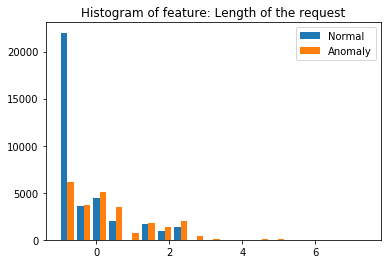

In [32]:
histogram_features(X,y,0)

Distribution of PUT, GET, POST requests, we can see that PUT requests are only used in anomalous HTTP request(800 occurences)

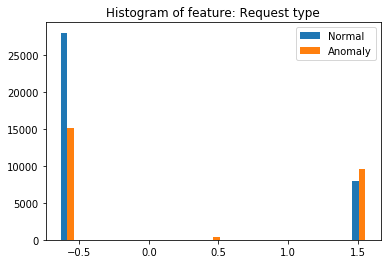

In [33]:
histogram_features(X,y,5)